In [50]:
import os
import numpy as np
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import glob

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")

In [56]:
# functions

def import_acropolis_system_data(years: list[int], id: int) -> pl.LazyFrame:
    paths = []
    df_years = []

    for year in years:
        paths += sorted(glob.glob(
            os.path.join(DATA_DIRECTORY, "output", "pipeline", str(year),
                         f"1min_acropolis-{id}.parquet")),
                        key=os.path.getmtime)

    for path in paths:
        df_years.append(pl.scan_parquet(path))

    return pl.concat(df_years,
                     how="diagonal").with_columns(system_id=pl.lit(id)).collect()
    
def join_picarro_data(df: pl.DataFrame, df_p: pl.DataFrame) -> pl.DataFrame:
    return df.sort("datetime") \
    .join_asof(df_p, on="datetime", tolerance='1m') \
    .group_by_dynamic("datetime", every='1h', group_by=["system_id", "system_name"]) \
    .agg([
            cs.numeric().mean(),
            pl.col("gmp343_corrected").std().alias("gmp343_corrected_std"),
            pl.col("gmp343_corrected").var().alias("gmp343_corrected_var")
        ])
            
def calculate_performance_metrics(df: pl.DataFrame, col:str = "gmp343_corrected") -> pl.DataFrame:
    return df.with_columns(diff = pl.col("CO2") - pl.col(col)) \
    .select((np.square(pl.col("diff")).mean()).alias("mse_full_deployment")) \
    .with_columns(pl.col("mse_full_deployment").sqrt().alias("rmse_full_deployment"))
    
def plot_column_difference(df: pl.DataFrame, datetime_col: str, col1: str, col2: str, sample_size: int = 10000, filter_value: int = 10):
    """
    Plots the difference between two columns over a datetime index.
    
    Parameters:
    - df (pl.DataFrame): The Polars DataFrame containing the columns.
    - datetime_col (str): The column name for datetime values.
    - col1 (str): The first column name.
    - col2 (str): The second column name.
    - sample_size (int): Number of points to sample for plotting (default=10,000).
    """
    # Ensure columns exist
    for col in [datetime_col, col1, col2]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Convert datetime column to proper format if needed
    if not isinstance(df[datetime_col].dtype, pl.Datetime):
        df = df.with_columns(pl.col(datetime_col).cast(pl.Datetime).alias(datetime_col))

    # Compute the difference
    df = df.with_columns((pl.col(col1) - pl.col(col2)).alias("difference")) \
        .filter(pl.col("difference") < filter_value) \
        .filter(pl.col("difference") > -filter_value)

    # Downsampling for large data
    num_rows = df.height
    if num_rows > sample_size:
        indices = np.linspace(0, num_rows - 1, sample_size, dtype=int)
        df_sampled = df[indices]
    else:
        df_sampled = df

    # Convert datetime to Python datetime for Matplotlib compatibility
    x_values = df_sampled[datetime_col].to_numpy()
    y_values = df_sampled["difference"].to_numpy()

    # Plot the difference with datetime on x-axis
    plt.figure(figsize=(12, 5))
    plt.plot(x_values, y_values, label=f"{col1} - {col2}", alpha=0.7, linewidth=1)

    # Format the x-axis for datetime
    plt.xlabel("Datetime")
    plt.ylabel("Difference")
    plt.title(f"Difference Between {col1} and {col2} Over Time")
    plt.legend()
    plt.grid(True)
    
    # Format date ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)

    plt.show()

In [52]:
PICARRO_DIR = "/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/data/input/picarro/Calibrated_1_min_ICOS_Picarro_G2401_529.parquet"

df_p_icos = pl.read_parquet(PICARRO_DIR)

start_date = datetime(2025, 2, 17, 15, 0, 0)
end_date = datetime(2025, 2 , 28, 0, 0, 0)

df_p_icos = df_p_icos.rename({"creation_timestamp": "datetime", "picarro_corrected": "CO2"}) \
    .select(["datetime", "CO2"]) \
    .with_columns(pl.col("datetime").cast(pl.Datetime("ms"))) \
    .filter(pl.col("datetime").is_between(start_date, end_date)) \
    .with_columns(system_name = pl.lit("Picarro_ICOS")) \
    .with_columns(system_id = pl.lit(529)) \
    .with_columns(pl.col("system_id").cast(pl.Int64))

In [53]:
df_3 = import_acropolis_system_data([2024,2025], 3).pipe(join_picarro_data, df_p_icos)
df_6 = import_acropolis_system_data([2024,2025], 6).pipe(join_picarro_data, df_p_icos)

In [58]:
print(calculate_performance_metrics(df_3, col="gmp343_corrected"))
print(calculate_performance_metrics(df_3, col="gmp343_edge_corrected"))

shape: (1, 2)
┌─────────────────────┬──────────────────────┐
│ mse_full_deployment ┆ rmse_full_deployment │
│ ---                 ┆ ---                  │
│ f64                 ┆ f64                  │
╞═════════════════════╪══════════════════════╡
│ 0.308166            ┆ 0.555127             │
└─────────────────────┴──────────────────────┘
shape: (1, 2)
┌─────────────────────┬──────────────────────┐
│ mse_full_deployment ┆ rmse_full_deployment │
│ ---                 ┆ ---                  │
│ f64                 ┆ f64                  │
╞═════════════════════╪══════════════════════╡
│ 0.333461            ┆ 0.577461             │
└─────────────────────┴──────────────────────┘


In [59]:
print(calculate_performance_metrics(df_6, col="gmp343_corrected"))
print(calculate_performance_metrics(df_6, col="gmp343_edge_corrected"))

shape: (1, 2)
┌─────────────────────┬──────────────────────┐
│ mse_full_deployment ┆ rmse_full_deployment │
│ ---                 ┆ ---                  │
│ f64                 ┆ f64                  │
╞═════════════════════╪══════════════════════╡
│ 0.726705            ┆ 0.85247              │
└─────────────────────┴──────────────────────┘
shape: (1, 2)
┌─────────────────────┬──────────────────────┐
│ mse_full_deployment ┆ rmse_full_deployment │
│ ---                 ┆ ---                  │
│ f64                 ┆ f64                  │
╞═════════════════════╪══════════════════════╡
│ 0.577875            ┆ 0.760181             │
└─────────────────────┴──────────────────────┘


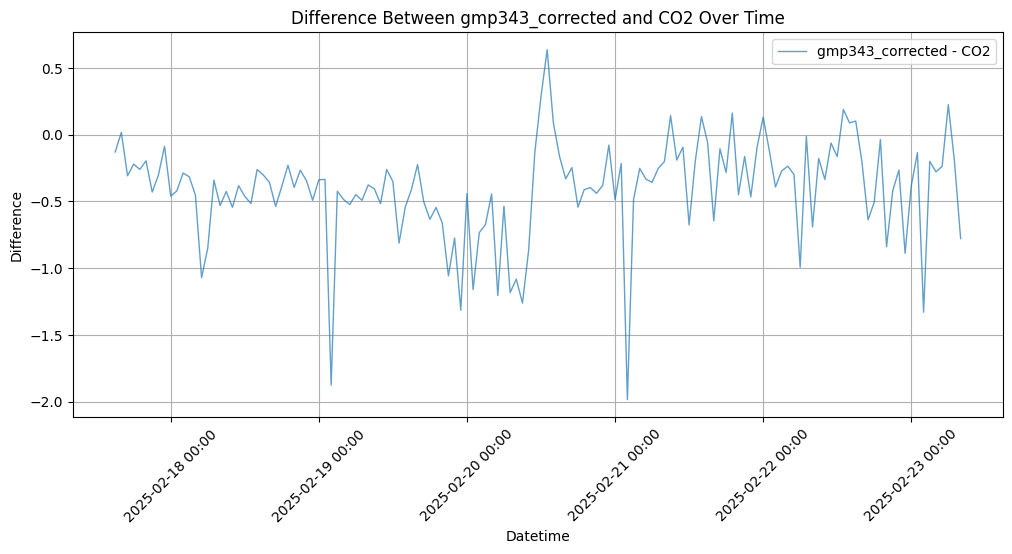

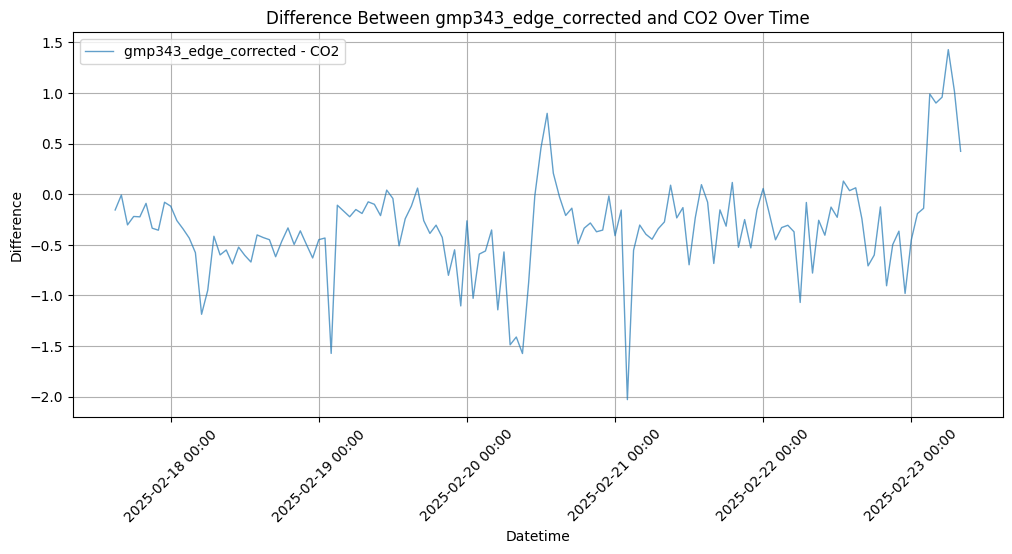

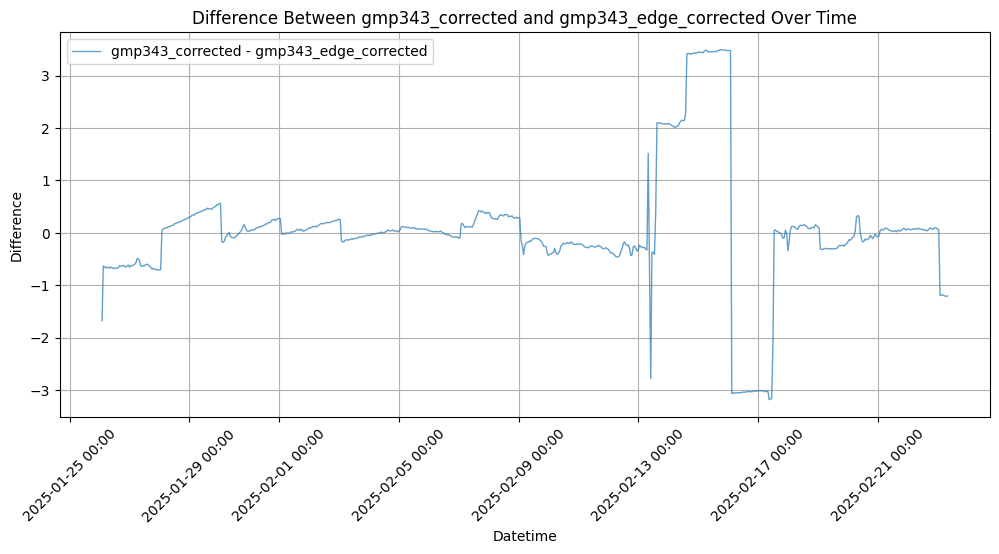

In [30]:
plot_column_difference(df_3, datetime_col="datetime", col1="gmp343_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_3, datetime_col="datetime", col1="gmp343_edge_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_3, datetime_col="datetime", col1="gmp343_corrected", col2="gmp343_edge_corrected", sample_size=100_000)

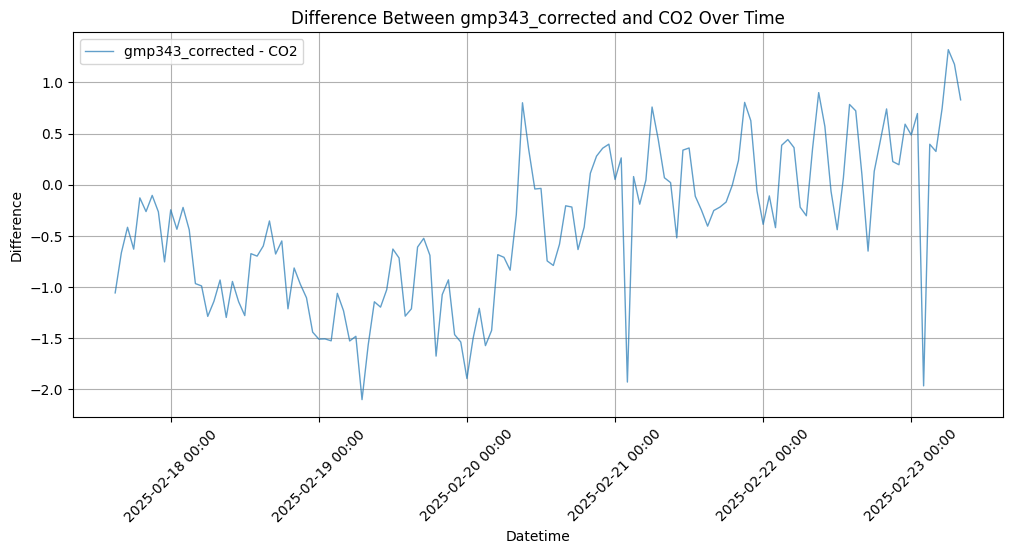

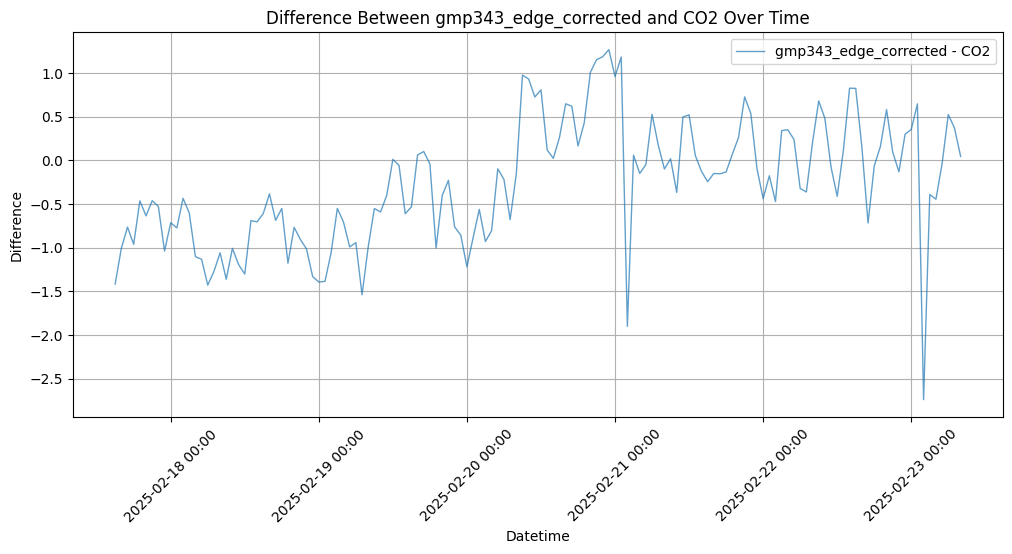

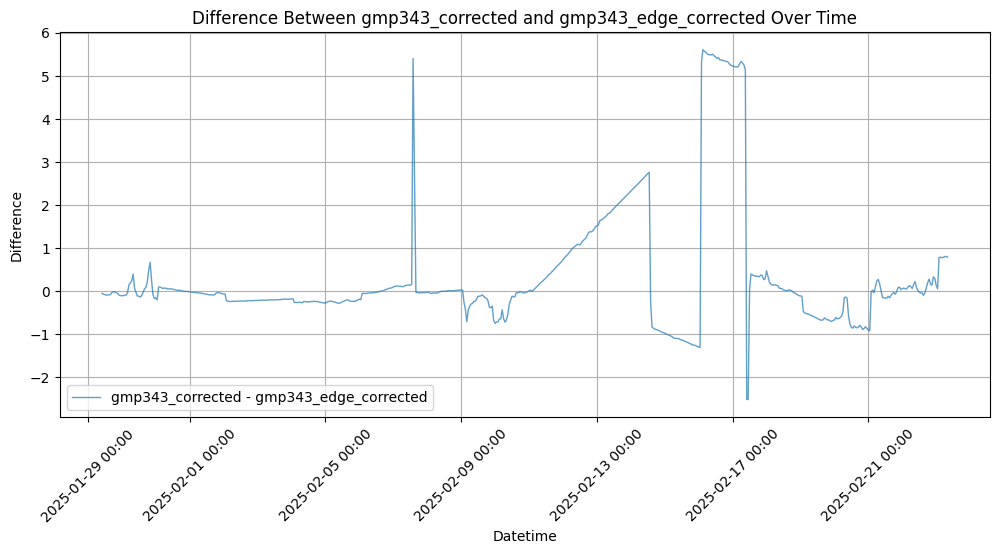

In [31]:
plot_column_difference(df_6, datetime_col="datetime", col1="gmp343_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_6, datetime_col="datetime", col1="gmp343_edge_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_6, datetime_col="datetime", col1="gmp343_corrected", col2="gmp343_edge_corrected", sample_size=100_000)